In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
# if gpus:    
#     for gpu in gpus:
#         tensorflow.config.set_logical_device_configuration(
#             gpu,
#             [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data


data_folder = '/home/rl_sim/thesis_ws/src/ML_Levers_Knobs/DATA/1D_AUGM_KNOB_FTP_ScalNorm'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

WS_B = 2000  # Example sequence length
input_shape1 = (WS_B, 1)
input_shape2 = (WS_B, 3)
input_shape3 = (WS_B, 2)

def assign_and_deploy_variables_v2(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = data[:, :, 5]
        globals()[f"{key}2"] = np.dstack((data[:, :, 0], data[:, :, 4], data[:, :, 2]))
        globals()[f"{key}3"] = np.dstack((data[:, :, 1], data[:, :, 3]))

data_dict = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test
}

assign_and_deploy_variables_v2(data_dict)

# Printing shapes
print("Shapes of the stacked arrays:")
print("X_train1 shape:", X_train1.shape)
print("X_train2 shape:", X_train2.shape)
print("X_train3 shape:", X_train3.shape)


import tensorflow as tf


2024-07-02 15:31:50.438765: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 15:31:50.465859: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 15:31:50.915825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-02 15:31:51.254641: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more 

X_data shape: (935, 2000, 9)
y_data shape: (935,)
X_data.[0] shape:  (2000, 9)
TOTAL DATA: 935  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (561, 2000, 9)    ||  Dimensions of y_train: (561,)
Dimensions of X_test:  (187, 2000, 9)    ||  Dimensions of y_test:  (187,)
Dimensions of X_val:   (187, 2000, 9)    ||  Dimensions of y_val:   (187,)
Shapes of the stacked arrays:
X_train1 shape: (561, 2000)
X_train2 shape: (561, 2000, 3)
X_train3 shape: (561, 2000, 2)


# 3ConvLayers FirstTry: FxFzTy + Tz + FyTx    had 93%

Epoch 1/80


2024-07-02 15:31:51.668959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-02 15:31:51.669116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-02 15:31:51.669240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - accuracy: 0.0625 - loss: 1.8160

I0000 00:00:1719927115.997194  125486 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.2258 - loss: 1.7413 - val_accuracy: 0.3155 - val_loss: 1.5515
Epoch 2/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4493 - loss: 1.3802 - val_accuracy: 0.3636 - val_loss: 1.5113
Epoch 3/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4332 - loss: 1.3541 - val_accuracy: 0.3209 - val_loss: 1.5009
Epoch 4/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4521 - loss: 1.3177 - val_accuracy: 0.4225 - val_loss: 1.3958
Epoch 5/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4113 - loss: 1.4256 - val_accuracy: 0.4011 - val_loss: 1.3966
Epoch 6/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4968 - loss: 1.2762 - val_accuracy: 0.3957 - val_loss: 1.3142
Epoch 7/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5428 - loss: 1.1117 - val_accuracy: 0.3636 - val_loss: 1.4698
Epoch 8/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5299 - loss: 1.1522 - val_accuracy: 0.5668 - val_loss: 1.2169
E

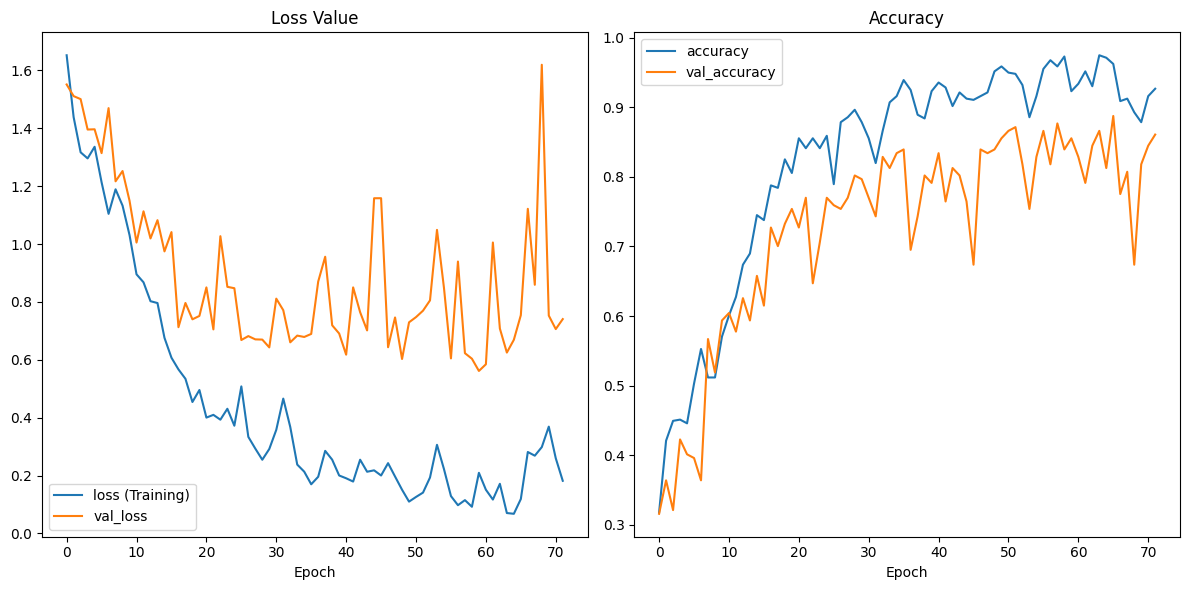

Test loss: 0.3703230917453766
Test accuracy: 0.9197860962566845
Accuracy Score: 0.9197860962566845
F1 Score: 0.9036336624784215
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.99        40
         1.0       0.98      0.91      0.94        54
         2.0       0.87      0.98      0.92        42
         3.0       1.00      0.86      0.92        14
         4.0       0.82      0.93      0.88        15
         5.0       0.77      0.77      0.77        22

    accuracy                           0.92       187
   macro avg       0.91      0.90      0.90       187
weighted avg       0.92      0.92      0.92       187



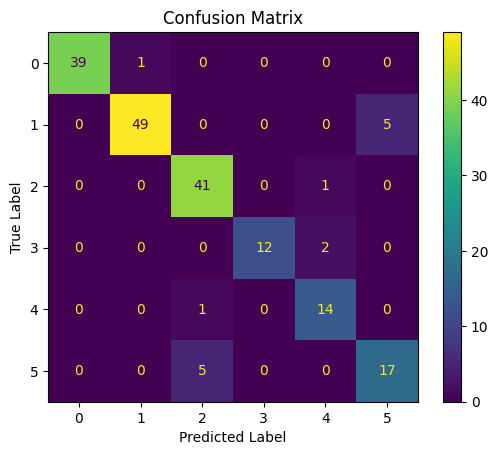

In [2]:
# Define the branched model
def build_branched_model(input_shape1, input_shape2, input_shape3):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64*2, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_1_1')(input1)
    # x1 = MaxPooling1D(pool_size=2, name='maxpool1d_1_1')(x1)
    x1 = Conv1D(filters=128*2, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256*2, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64*2, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_2_1')(input2)
    # x2 = MaxPooling1D(pool_size=2, name='maxpool1d_2_1')(x2)
    x2 = Conv1D(filters=128*2, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=256*2, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64*2, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_3_1')(input3)
    # x3 = MaxPooling1D(pool_size=2, name='maxpool1d_3_1')(x3)
    x3 = Conv1D(filters=128*2, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=256*2, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Concatenate the outputs of the three branches
    merged = concatenate([x1, x2, x3], name='concatenate_1')
    
    # Dense layer
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(6, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3], outputs=output)
    return model

# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3)
#model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit([X_train1, X_train2, X_train3], y_train, epochs=80, batch_size=32, validation_data=([X_val1, X_val2, X_val3], y_val), verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3])
y_pred_labels = np.argmax(y_pred, axis=1)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()


f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)

print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[0, 1, 2, 3, 4, 5])
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


global n1 
n1 = 0

In [3]:
# model_name = "ALL_KNOB_3Cnv2Dens_93"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

In [4]:
# # WORKS !!
# print("Predicted Label: ",y_pred_labels[n1])
# plot_grad_cam(model, [X_test1, X_test2, X_test3], n1, y_test, ['conv1d_1_3', 'conv1d_2_3', 'conv1d_3_3'])
# n1+=1

# 3Conv

Epoch 1/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.2868 - loss: 1.6560 - val_accuracy: 0.3850 - val_loss: 1.4864
Epoch 2/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4988 - loss: 1.2342 - val_accuracy: 0.3743 - val_loss: 1.3564
Epoch 3/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5175 - loss: 1.0503 - val_accuracy: 0.5134 - val_loss: 1.0277
Epoch 4/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6411 - loss: 0.7968 - val_accuracy: 0.6364 - val_loss: 0.8825
Epoch 5/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7118 - loss: 0.7033 - val_accuracy: 0.6898 - val_loss: 0.7929
Epoch 6/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7846 - loss: 0.5131 - val_accuracy: 0.7861 - val_loss: 0.5844
Epoch 7/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8366 - loss: 0.4884 - val_accuracy: 0.7647 - val_loss: 0.8464
Epoch 8/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8632 - loss: 0.4052 - val_accuracy: 0.8021 - val_lo

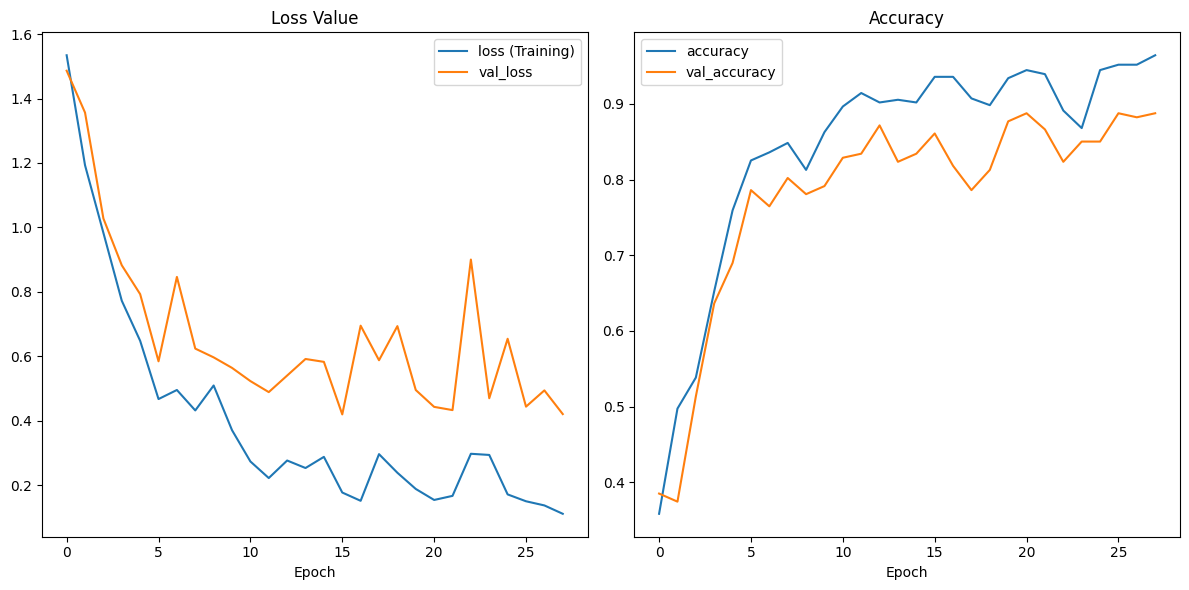

Test loss: 0.23229582607746124
Test accuracy: 0.9037433155080213
Accuracy Score: 0.9037433155080213
F1 Score: 0.8895856387235966
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        40
         1.0       0.96      0.87      0.91        54
         2.0       0.85      0.98      0.91        42
         3.0       1.00      0.79      0.88        14
         4.0       0.88      0.93      0.90        15
         5.0       0.74      0.77      0.76        22

    accuracy                           0.90       187
   macro avg       0.90      0.89      0.89       187
weighted avg       0.91      0.90      0.90       187



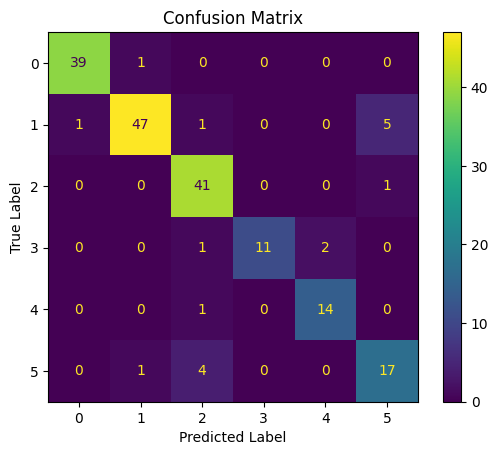

In [5]:
def build_branched_model(input_shape1, input_shape2, input_shape3):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64*2, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_1_1')(input1)
    x1 = MaxPooling1D(pool_size=2, name='maxpool1d_1_1')(x1)
    x1 = Conv1D(filters=128*2, kernel_size=8, strides=4, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256*2, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64*2, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_2_1')(input2)
    x2 = MaxPooling1D(pool_size=2, name='maxpool1d_2_1')(x2)
    x2 = Conv1D(filters=128*2, kernel_size=8, strides=4, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=256*2, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64*2, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_3_1')(input3)
    x3 = MaxPooling1D(pool_size=2, name='maxpool1d_3_1')(x3)
    x3 = Conv1D(filters=128*2, kernel_size=8, strides=4, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=256*2, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Concatenate the outputs of the three branches
    merged = concatenate([x1, x2, x3], name='concatenate_1')
    
    # Dense layer
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(6, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3], outputs=output)
    return model

# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3)
#model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit([X_train1, X_train2, X_train3], y_train, epochs=90, batch_size=32, validation_data=([X_val1, X_val2, X_val3], y_val), verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3])
y_pred_labels = np.argmax(y_pred, axis=1)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()


f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)

print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[0, 1, 2, 3, 4, 5])
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


global n2
n2=0

In [6]:
# model_name = "ALL_KNOB_3Cnv1_den_AUGM_halfstride_95"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

In [7]:
# # WORKS !!
# print("Predicted Label: ",y_pred_labels[n2])
# plot_grad_cam(model, [X_test1, X_test2, X_test3], n2, y_test, ['conv1d_1_3', 'conv1d_2_3', 'conv1d_3_3'])
# n2+=1

# 4 ConvLayers

Epoch 1/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.2538 - loss: 1.6293 - val_accuracy: 0.5829 - val_loss: 1.0540
Epoch 2/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6586 - loss: 0.8903 - val_accuracy: 0.6524 - val_loss: 0.8406
Epoch 3/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7421 - loss: 0.6481 - val_accuracy: 0.7273 - val_loss: 0.6464
Epoch 4/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7997 - loss: 0.4810 - val_accuracy: 0.7433 - val_loss: 0.5976
Epoch 5/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7939 - loss: 0.4741 - val_accuracy: 0.7487 - val_loss: 0.5389
Epoch 6/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8206 - loss: 0.4649 - val_accuracy: 0.8717 - val_loss: 0.3915
Epoch 7/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8324 - loss: 0.3552 - val_accuracy: 0.8128 - val_loss: 0.5717
Epoch 8/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8868 - loss: 0.3253 - val_accuracy: 0.8342 - val_los

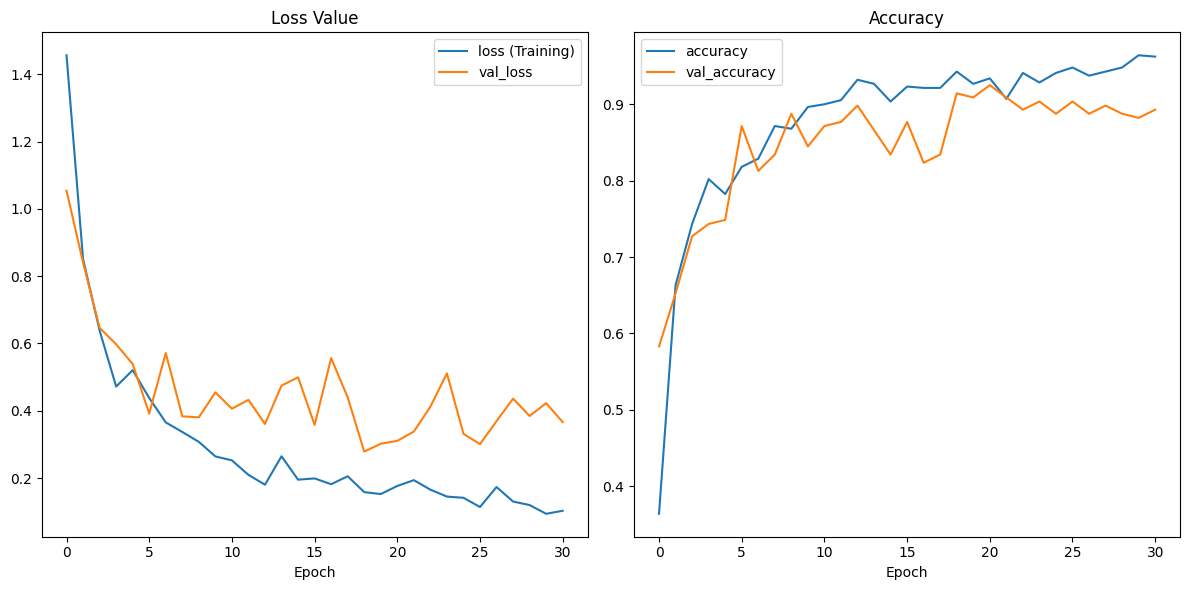

Test loss: 0.25133246183395386
Test accuracy: 0.9144385026737968
Accuracy Score: 0.9144385026737968
F1 Score: 0.9143286034197474
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95        40
         1.0       0.90      0.87      0.89        54
         2.0       0.95      0.98      0.96        42
         3.0       0.93      1.00      0.97        14
         4.0       1.00      0.87      0.93        15
         5.0       0.73      0.86      0.79        22

    accuracy                           0.91       187
   macro avg       0.92      0.92      0.91       187
weighted avg       0.92      0.91      0.92       187



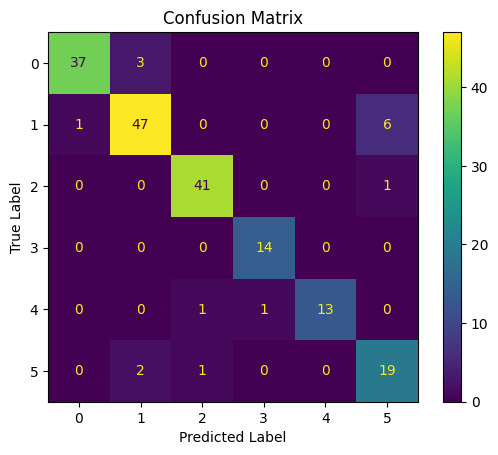

In [8]:
def build_branched_model(input_shape1, input_shape2, input_shape3):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64*2, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_1_0')(input1)
    x1 = Conv1D(filters=128*2, kernel_size=20, strides=8, activation='relu', name='conv1d_1_1')(x1)
    x1 = Conv1D(filters=256*1, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256*2, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)

    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64*2, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_2_0')(input2)
    x2 = Conv1D(filters=128*2, kernel_size=20, strides=8, activation='relu', name='conv1d_2_1')(x2)
    x2 = Conv1D(filters=256*1, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=256*2, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)

    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64*2, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_3_0')(input3)
    x3 = Conv1D(filters=128*2, kernel_size=20, strides=8, activation='relu', name='conv1d_3_1')(x3)
    x3 = Conv1D(filters=256*1, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=256*2, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)

    # Concatenate the outputs of the three branches
    merged = concatenate([x1, x2, x3], name='concatenate_1')

    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)

    # Output layer for 6-class classification
    output = Dense(6, activation='softmax', name='output')(dense)

    # Create the model
    model = Model(inputs=[input1, input2, input3], outputs=output)

    return model


# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3)
#model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit([X_train1, X_train2, X_train3], y_train, epochs=90, batch_size=32, validation_data=([X_val1, X_val2, X_val3], y_val), verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3])
y_pred_labels = np.argmax(y_pred, axis=1)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()


f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)

print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[0, 1, 2, 3, 4, 5])
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()